### Definitions, imports, and settings

In [12]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches, colors, cm
from astropy.table import Table
from scipy.stats import norm
from scipy.optimize import curve_fit

# Plot settings
plt.rc(('xtick', 'ytick'), direction='in')
plt.rc('xtick', top=True)
plt.rc('ytick', right=True)
plt.rc('font', family='STIXgeneral')
plt.rc('figure', dpi=140)

# Paths
# data_dir = '/users/PAS2055/lodubay/Data/APOGEE'
# data_dir = 'C:\\Users\\dubay.11\\Data\\APOGEE'
data_dir = '/home/dubay.11/Documents/Data/APOGEE'
data_path = Path(data_dir)
apokasc_file = 'APOKASC_cat_v6.7.2.fits'
starhorse_file = 'APOGEE_DR17_EDR3_STARHORSE_v2.fits'
astroNN_file = 'apogee_astroNN-DR17.fits'
bacchus_file = 'dr17_nc_abund_v1_0.fits'

def decode(df):
    """
    Decode DataFrame with byte strings into ordinary strings.

    """
    str_df = df.select_dtypes([object])
    str_df = str_df.stack().str.decode('utf-8').unstack()
    for col in str_df:
        df[col] = str_df[col]
    return df

def rms(array, arrmin=None, arrmax=None, axis=None):
    """
    Return the root-mean-square of a given array

    """
    if arrmin:
        array = array[array > arrmin]
    if arrmax:
        array = array[array < arrmax]
    return np.sqrt(np.mean(array**2, axis=axis))

def quad_add(arr1, arr2):
    """
    Add input arrays in quadrature.
    
    """
    return np.sqrt(arr1**2 + arr2**2)

### Import and combine data

In [14]:
# APOKASC catalog
print('Importing APOKASC catalog...')
data = Table.read(data_path / apokasc_file, format='fits')
apokasc_df = decode(data.to_pandas())
# apokasc_df['LOC_ID'] = apokasc_df['LOC_ID'].astype(int)
# Relevant columns
apokasc_cols = ['2MASS_ID', #'LOC_ID', 
                'APOKASC2_AGE', 'APOKASC2_AGE_MERR', 
                'APOKASC2_AGE_PERR', 'DR16_ALP_M_COR', 'DR16_ALP_M_COR_ERR', 
                'DR16_FE_H', 'DR16_FE_H_ERR', 'DR16_M_H_COR', 
                'DR16_M_H_COR_ERR', 'DR16_O_FE', 'DR16_O_FE_ERR',
                'DR16_ASPCAP_SNR',
                'GAIA_PARALLAX_DR2', 'GAIA_PARALLAX_ERROR_DR2',
                'GAIA_PHOT_G_MEAN_MAG_DR2', 'GAIA_PHOT_BP_MEAN_MAG_DR2',
                'GAIA_PHOT_RP_MEAN_MAG_DR2', 'APOKASC2_AV',
                'DR16_LOGG_COR', 'DR16_LOGG_COR_ERR']

# astroNN DR17 catalog
print('Importing astroNN DR17 catalog...')
data = Table.read(data_path / astroNN_file, format='fits')
astroNN_df = decode(data.to_pandas())
astroNN_cols = ['APOGEE_ID', #'LOCATION_ID', 
                'age_lowess_correct', 'age_total_error',
                'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'C_H', 'C_H_ERR', 
                'N_H', 'N_H_ERR', 'O_H', 'O_H_ERR', 'TI_H', 'TI_H_ERR', 'FE_H', 'FE_H_ERR']

# StarHorse DR17 catalog
print('Importing StarHorse DR17 catalog...')
data = Table.read(data_path / starhorse_file, format='fits')
starhorse_df = decode(data.to_pandas())
print(starhorse_df[['APOGEE_ID', 'ASPCAP_ID', 'APSTAR_ID']])
starhorse_cols = ['APOGEE_ID', 'met16', 'met50', 'met84']

# BACCHUS neutron capture abundance catalog
# print('Importing BACCHUS catalog...')
# data = Table.read(data_path / bacchus_file, format='fits', hdu=1)
# multd_names = [name for name in data.colnames if len(data[name].shape) <= 1]
# bacchus_df = decode(data[multd_names].to_pandas())
# bacchus_cols = ['APOGEE_ID', 'C12C13', 'C12C13_ERR_MEAS', 'C12C13_ERR_EMP']

# Consolidate into single DataFrame
print('Combining datasets...')
stellar_params = apokasc_df[apokasc_cols].rename(columns={'2MASS_ID': 'APOGEE_ID'})#, 'LOC_ID': 'LOCATION_ID'})
# stellar_params = stellar_params.join(astroNN_df[astroNN_cols].set_index(['APOGEE_ID', 'LOCATION_ID']), 
#                                      on=['APOGEE_ID', 'LOCATION_ID'], how='outer', rsuffix='_astroNN')
stellar_params = stellar_params.join(astroNN_df[astroNN_cols].set_index('APOGEE_ID'), 
                                     on='APOGEE_ID', how='outer', rsuffix='_astroNN')
stellar_params = stellar_params.join(starhorse_df[starhorse_cols].set_index('APOGEE_ID'), 
                                     on='APOGEE_ID', how='outer', rsuffix='_StarHorse')
# stellar_params = stellar_params.join(bacchus_df[bacchus_cols].set_index('APOGEE_ID'),
#                                      on='APOGEE_ID', how='outer', rsuffix='_BACCHUS')
# Clean up
stellar_params.replace([np.inf, -np.inf, -9999., -9999.99, -999., -999.99], np.nan, inplace=True)
stellar_params.dropna(how='all', inplace=True)
# TODO better way to deal with astroNN duplicates (same APOGEE_ID, different LOCATION_ID)
stellar_params.drop_duplicates(subset='APOGEE_ID', inplace=True)
stellar_params.set_index('APOGEE_ID', inplace=True)
# Rename columns
mapper = dict([(col, 'ASTRONN_'+col) for col in astroNN_cols[3:]])
stellar_params.rename(columns=mapper, inplace=True)
stellar_params.rename(columns={'age_lowess_correct': 'ASTRONN_AGE', 'age_total_error': 'ASTRONN_AGE_ERR', 'met50': 'STARHORSE_M_H'}, 
                      inplace=True)
# Combine columns
stellar_params['STARHORSE_M_H_MERR'] = stellar_params['STARHORSE_M_H'] - stellar_params['met16']
stellar_params['STARHORSE_M_H_PERR'] = stellar_params['met84'] - stellar_params['STARHORSE_M_H']
stellar_params.drop(['met16', 'met84'], axis='columns', inplace=True)
stellar_params['ASTRONN_C_N'] = stellar_params['ASTRONN_C_H'] - stellar_params['ASTRONN_N_H']
stellar_params['ASTRONN_C_N_ERR'] = quad_add(stellar_params['ASTRONN_C_H_ERR'], stellar_params['ASTRONN_N_H_ERR'])
stellar_params['ASTRONN_O_FE'] = stellar_params['ASTRONN_O_H'] - stellar_params['ASTRONN_FE_H']
stellar_params['ASTRONN_O_FE_ERR'] = quad_add(stellar_params['ASTRONN_O_H_ERR'], stellar_params['ASTRONN_FE_H_ERR'])
stellar_params['ASTRONN_TI_FE'] = stellar_params['ASTRONN_TI_H'] - stellar_params['ASTRONN_FE_H']
stellar_params['ASTRONN_TI_FE_ERR'] = quad_add(stellar_params['ASTRONN_TI_H_ERR'], stellar_params['ASTRONN_FE_H_ERR'])
print('Done!')

Importing APOKASC catalog...
Importing astroNN DR17 catalog...
Importing StarHorse DR17 catalog...
                 APOGEE_ID                                          ASPCAP_ID  \
0       2M01151487-7321065          apogee.lco25m.l33.SMC5.2M01151487-7321065   
1       2M01151488+0559144  apogee.apo25m.l33.K2_C8_133-55_btx.2M01151488+...   
2       2M01151527+1409194    apogee.apo25m.l33.131-48_MGA.2M01151527+1409194   
3       2M01151531-7316573          apogee.lco25m.l33.SMC5.2M01151531-7316573   
4       2M01151534+0113001  apogee.apo25m.l33.K2_C8_137-61_btx.2M01151534+...   
...                    ...                                                ...   
562419  2M01151266-7238282          apogee.lco25m.l33.SMC5.2M01151266-7238282   
562420  2M01151351+1430322    apogee.apo25m.l33.131-48_MGA.2M01151351+1430322   
562421  2M01151374-7505536          apogee.lco25m.l33.SMC4.2M01151374-7505536   
562422  2M01151472-7302513          apogee.lco25m.l33.SMC5.2M01151472-7302513   
562423  2M

In [3]:
# Print sample stats
print('~ Sample info ~\n')
print('APOKASC sample:', apokasc_df.shape[0])
print('astroNN sample:', astroNN_df.shape[0])
print('StarHorse sample:', starhorse_df.shape[0])
print('Total sample (no duplicates):', stellar_params.shape[0], '\n')

print('APOKASC ages:', stellar_params[pd.notna(stellar_params['APOKASC2_AGE'])].shape[0])
print('astroNN ages:', stellar_params[pd.notna(stellar_params['ASTRONN_AGE'])].shape[0])
print('Both ages:', stellar_params[pd.notna(stellar_params['APOKASC2_AGE']) & 
                                   pd.notna(stellar_params['ASTRONN_AGE'])].shape[0], '\n')

print('APOKASC metallicities:', stellar_params[pd.notna(stellar_params['DR16_M_H_COR'])].shape[0])
print('astroNN metallicities:', stellar_params[pd.notna(stellar_params['ASTRONN_FE_H'])].shape[0])
print('StarHorse metallicities:', stellar_params[pd.notna(stellar_params['STARHORSE_M_H'])].shape[0])
print('All metallicities:', stellar_params[pd.notna(stellar_params['DR16_M_H_COR']) & 
                                           pd.notna(stellar_params['ASTRONN_FE_H']) &
                                           pd.notna(stellar_params['STARHORSE_M_H'])].shape[0], '\n')

print('APOKASC ages and metallicites:', 
      stellar_params[pd.notna(stellar_params['APOKASC2_AGE']) & 
                     pd.notna(stellar_params['DR16_M_H_COR'])].shape[0])
print('astroNN ages and metallicites:', 
      stellar_params[pd.notna(stellar_params['ASTRONN_AGE']) & 
                     pd.notna(stellar_params['ASTRONN_FE_H'])].shape[0])
print('APOKASC and astroNN ages and metallicites:', 
      stellar_params[pd.notna(stellar_params['APOKASC2_AGE']) & 
                     pd.notna(stellar_params['DR16_M_H_COR']) & 
                     pd.notna(stellar_params['ASTRONN_AGE']) & 
                     pd.notna(stellar_params['ASTRONN_FE_H'])].shape[0])
print('All ages and metallicities (inc. StarHorse):', 
      stellar_params[pd.notna(stellar_params['APOKASC2_AGE']) & 
                     pd.notna(stellar_params['ASTRONN_AGE']) &
                     pd.notna(stellar_params['DR16_M_H_COR']) & 
                     pd.notna(stellar_params['ASTRONN_FE_H']) & 
                     pd.notna(stellar_params['STARHORSE_M_H'])].shape[0], '\n')

~ Sample info ~

APOKASC sample: 23363
astroNN sample: 733901
StarHorse sample: 562424
Total sample (no duplicates): 657136 

APOKASC ages: 6522
astroNN ages: 628346
Both ages: 6521 

APOKASC metallicities: 22233
astroNN metallicities: 628595
StarHorse metallicities: 562424
All metallicities: 21611 

APOKASC ages and metallicites: 6514
astroNN ages and metallicites: 628345
APOKASC and astroNN ages and metallicites: 6513
All ages and metallicities (inc. StarHorse): 6488 



### Age comparison

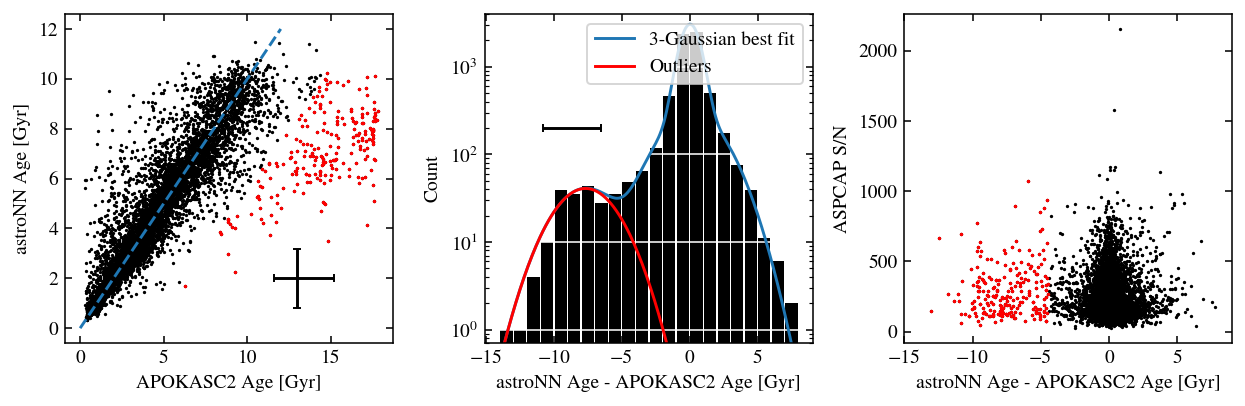

Best fit parameters
sigma1: 0.688124611756609
sigma2: 2.1115427809268073
loc3:  -7.67104634027151
sigma3: 2.0951728777850636
Sample within sigma2: 5831 or 89%


In [15]:
# Select targets with ages from both APOKASC and astroNN
ages = stellar_params[(pd.notna(stellar_params['APOKASC2_AGE'])) & 
                      (pd.notna(stellar_params['ASTRONN_AGE'])) &
                      (pd.notna(stellar_params['APOKASC2_AGE_PERR']))].copy()

age_diff = ages['ASTRONN_AGE'] - ages['APOKASC2_AGE']
age_diff_err = np.array([quad_add(ages['ASTRONN_AGE_ERR'], ages['APOKASC2_AGE_MERR']),
                         quad_add(ages['ASTRONN_AGE_ERR'], ages['APOKASC2_AGE_PERR'])])
rms_diff_err = np.array([rms(age_diff_err, axis=1)]).transpose()

def trimodal_norm(x, loc1, scale1, a1, loc2, scale2, a2, loc3, scale3, a3):
    """Bimodal Gaussian to fit to age difference."""
    return a1 * norm.pdf(x, loc1, scale1) + a2 * norm.pdf(x, loc2, scale2) + a3 * norm.pdf(x, loc3, scale3)

# APOKASC age vs astroNN age
fig, axs = plt.subplots(1, 3, figsize=(9, 3), tight_layout=True)

# Histrogram of age differences
ax = axs[1]
xmin = -14
xmax = 8
bins = np.linspace(xmin, xmax, xmax-xmin+1)
y, x, _ = ax.hist(ages['ASTRONN_AGE'] - ages['APOKASC2_AGE'], 
                  color='k', bins=bins, rwidth=0.9)
x = x[:-1] + (x[1] - x[0])/2
ax.grid(which='major', axis='y', color='w')
# plot RMS error
ax.errorbar(-9, 200, 
            xerr=rms_diff_err, 
            color='k', capsize=2)
# best fit bimodal normal
params, cov = curve_fit(trimodal_norm, x, y, p0=(0, 0.5, 5e3, 0, 2, 1e3, -9, 2, 40))
x_fine = np.arange(xmin, xmax, 0.1)
ax.plot(x_fine, trimodal_norm(x_fine, *params), label='3-Gaussian best fit')
# individual distributions
# ax.plot(x_fine, params[2] * norm.pdf(x_fine, *params[0:2]))
# ax.plot(x_fine, params[5] * norm.pdf(x_fine, *params[3:5]))
ax.plot(x_fine, params[8] * norm.pdf(x_fine, *params[6:8]), c='r', label='Outliers')
# plot settings
ax.set_yscale('log')
ax.set_xlabel('astroNN Age - APOKASC2 Age [Gyr]')
ax.set_ylabel('Count')
ax.set_ylim((7e-1, 4e3))
ax.legend()

def prob_outlier(x):
    p_center = params[2] * norm.pdf(x, *params[0:2]) + params[5] * norm.pdf(x, *params[3:5])
    p_out = params[8] * norm.pdf(x, *params[6:8])
    return p_out / p_center

# Scatter plot of ages
ax = axs[0]
ax.plot([0, 12], [0, 12], linestyle='--')
ax.scatter(ages['APOKASC2_AGE'], ages['ASTRONN_AGE'], s=0.5, c='k')
outliers = ages[prob_outlier(age_diff) > 0.5]
ax.scatter(outliers['APOKASC2_AGE'], outliers['ASTRONN_AGE'], s=0.6, c='r')
# plot RMS error
ax.errorbar(13, 2, 
            xerr=[[rms(ages['APOKASC2_AGE_MERR'])],
                  [rms(ages['APOKASC2_AGE_PERR'])]], 
            yerr=rms(ages['ASTRONN_AGE_ERR']),
            color='k', capsize=2)
ax.set_xlabel('APOKASC2 Age [Gyr]')
ax.set_ylabel('astroNN Age [Gyr]')

ax = axs[2]
ax.scatter(age_diff, ages['DR16_ASPCAP_SNR'], s=.5, c='k')
ax.scatter(outliers['ASTRONN_AGE'] - outliers['APOKASC2_AGE'], outliers['DR16_ASPCAP_SNR'], s=.6, c='r')
ax.set_xlim((-15, 9))
ax.set_xlabel('astroNN Age - APOKASC2 Age [Gyr]')
ax.set_ylabel('ASPCAP S/N')
plt.savefig('age_comp.png')
plt.show()

print('Best fit parameters')
print('sigma1:', params[1])
print('sigma2:', params[4])
print('loc3: ', params[6])
print('sigma3:', params[7])
small_diff = age_diff[np.abs(age_diff) < params[4]]
print('Sample within sigma2:', small_diff.size, f'or {small_diff.size/age_diff.size*100:.0f}%')

In [5]:
# List of IDs for stars with big age differences
age_discrep = ages[(ages['ASTRONN_AGE'] - ages['APOKASC2_AGE']) < -5].copy()
age_discrep['AGE_DIFF'] = age_discrep['ASTRONN_AGE'] - age_discrep['APOKASC2_AGE']
age_discrep.to_csv('age_discrep.csv')

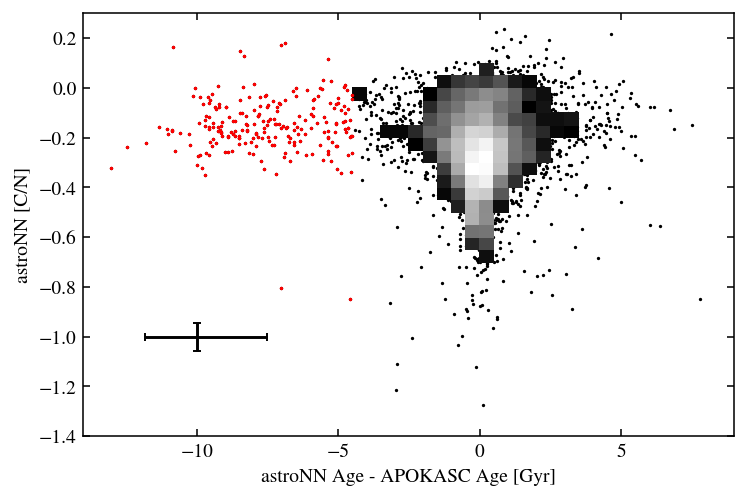

In [23]:
# Age difference vs C/N
ages = stellar_params[(pd.notna(stellar_params['APOKASC2_AGE'])) & 
                      (pd.notna(stellar_params['ASTRONN_AGE'])) &
                      (pd.notna(stellar_params['APOKASC2_AGE_PERR']))].copy()

age_diff = ages['ASTRONN_AGE'] - ages['APOKASC2_AGE']
age_diff_err = np.array([quad_add(ages['ASTRONN_AGE_ERR'], ages['APOKASC2_AGE_MERR']),
                         quad_add(ages['ASTRONN_AGE_ERR'], ages['APOKASC2_AGE_PERR'])])
rms_diff_err = np.array([rms(age_diff_err, axis=1)]).transpose()

fig, ax = plt.subplots()
ax.scatter(age_diff, ages['ASTRONN_C_N'], c='k', s=.5)
ax.hist2d(age_diff, ages['ASTRONN_C_N'], 
          bins=[np.arange(-5, 5.5, 0.5), np.arange(-0.8, 0.25, 0.05)], 
          cmap='gray', norm=colors.LogNorm(), cmin=10)
ax.scatter(outliers['ASTRONN_AGE'] - outliers['APOKASC2_AGE'], 
           outliers['ASTRONN_C_N'], c='r', s=.6)
# plot RMS errors added in quadrature
ax.errorbar(-10, -1, 
            xerr=rms_diff_err,
            yerr=rms(ages['ASTRONN_C_N_ERR']),
            color='k', capsize=2)
ax.set_xlim((-14, 9))
ax.set_ylim(-1.4, 0.3)
ax.set_xlabel('astroNN Age - APOKASC Age [Gyr]')
ax.set_ylabel('astroNN [C/N]')
plt.savefig('agediff_CN.png')
plt.show()

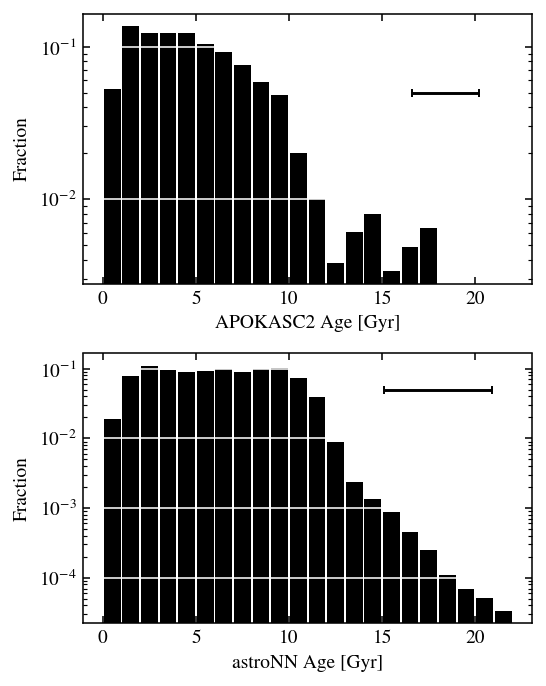

In [7]:
# Histogram of astroNN ages

fig, axs = plt.subplots(2, tight_layout=True, figsize=(4, 5))
bins = np.arange(0, 23, 1)
ax = axs[0]
ax.hist(stellar_params['APOKASC2_AGE'], color='k', rwidth=0.9, bins=bins, density=True)
ax.grid(which='major', axis='y', color='w')
ax.errorbar(18, 0.05,
            xerr=[[rms(stellar_params['APOKASC2_AGE_MERR'])],
                  [rms(stellar_params['APOKASC2_AGE_PERR'])]],
            color='k', capsize=2)
ax.set_yscale('log')
ax.set_xlabel('APOKASC2 Age [Gyr]')
ax.set_ylabel('Fraction')

ax = axs[1]
ax.hist(stellar_params['ASTRONN_AGE'], color='k', rwidth=0.9, bins=bins, density=True)
ax.grid(which='major', axis='y', color='w')
ax.errorbar(18, 0.05,
            xerr=rms(stellar_params['ASTRONN_AGE_ERR']),
            color='k', capsize=2)
ax.set_yscale('log')
ax.set_xlabel('astroNN Age [Gyr]')
ax.set_ylabel('Fraction')
plt.show()

### Alpha abundance comparison

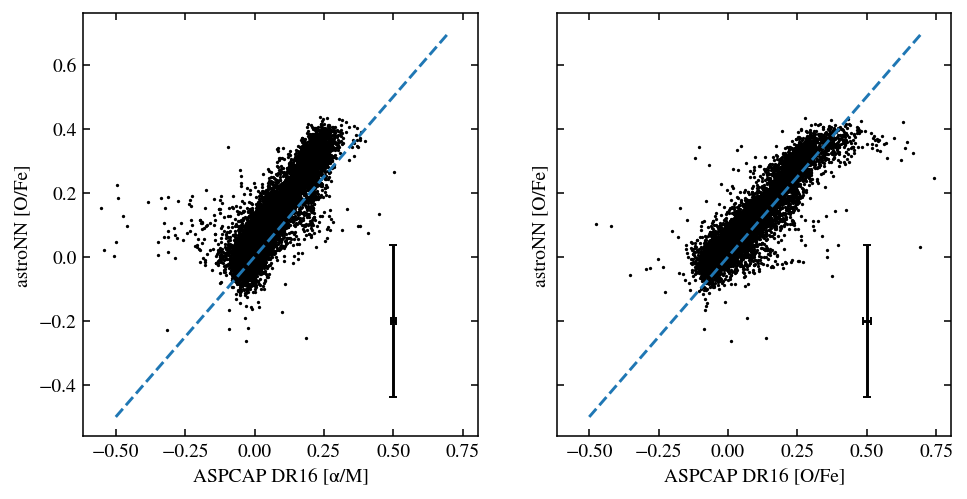

In [8]:
# select targets with alpha (O) abundances from APOKASC and astroNN
alphas = stellar_params[(pd.notna(stellar_params['DR16_ALP_M_COR'])) & (pd.notna(stellar_params['ASTRONN_O_FE']))].copy()

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax = axs[0]
ax.scatter(alphas['DR16_ALP_M_COR'], alphas['ASTRONN_O_FE'], c='k', s=0.5)
ax.plot([-0.5, 0.7], [-0.5, 0.7], linestyle='--')
ax.errorbar(0.5, -0.2, xerr=rms(alphas['DR16_ALP_M_COR_ERR']), yerr=rms(alphas['ASTRONN_O_FE_ERR']), capsize=2, color='k')
ax.set_xlabel('ASPCAP DR16 [α/M]')
ax.set_ylabel('astroNN [O/Fe]')

ax = axs[1]
ax.scatter(alphas['DR16_O_FE'], alphas['ASTRONN_O_FE'], c='k', s=0.5)
ax.plot([-0.5, 0.7], [-0.5, 0.7], linestyle='--')
ax.errorbar(0.5, -0.2, xerr=rms(alphas['DR16_O_FE_ERR']), yerr=rms(alphas['ASTRONN_O_FE_ERR']), capsize=2, color='k')
ax.set_xlabel('ASPCAP DR16 [O/Fe]')
ax.set_ylabel('astroNN [O/Fe]')
plt.show()

### Iron abundance / metallicity comparison

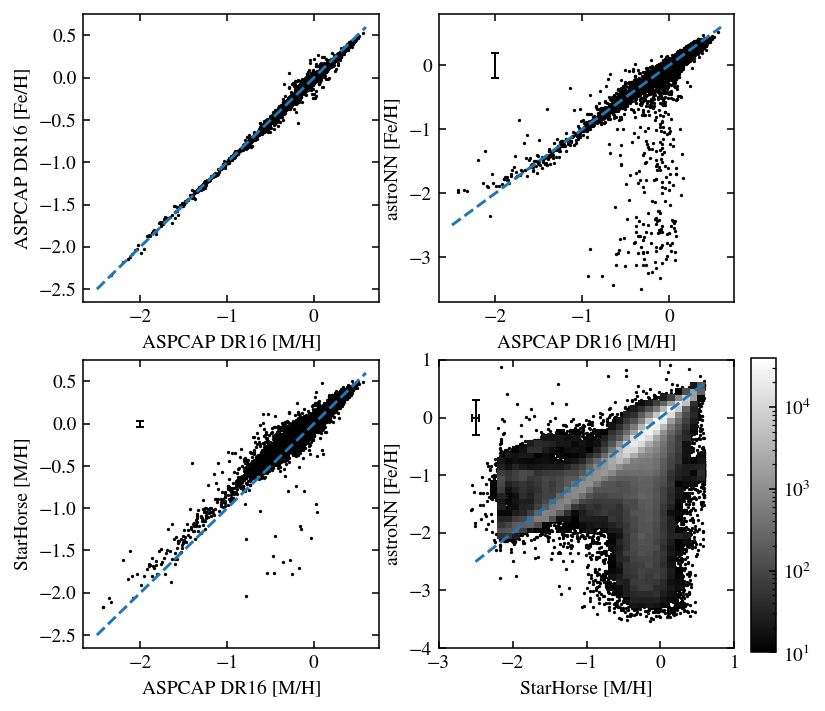

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

# APOKASC Fe/H vs M/H
ax = axs[0, 0]
metals = stellar_params[(pd.notna(stellar_params['DR16_M_H_COR'])) & (pd.notna(stellar_params['DR16_FE_H']))].copy()
ax.scatter(metals['DR16_M_H_COR'], metals['DR16_FE_H'], c='k', s=.5)
# Reported errors are too small to be noticeable
ax.plot([-2.5, 0.6], [-2.5, 0.6], linestyle='--')
ax.set_xlabel('ASPCAP DR16 [M/H]')
ax.set_ylabel('ASPCAP DR16 [Fe/H]')

# APOKASC vs astroNN
ax = axs[0, 1]
metals = stellar_params[(pd.notna(stellar_params['ASTRONN_FE_H'])) & (pd.notna(stellar_params['DR16_M_H_COR']))].copy()
ax.scatter(metals['DR16_M_H_COR'], metals['ASTRONN_FE_H'], c='k', s=.5)
ax.plot([-2.5, 0.6], [-2.5, 0.6], linestyle='--')
ax.errorbar(-2, 0, 
#             xerr=rms(metals['DR16M_H_COR_ERR']), 
            yerr=rms(metals['ASTRONN_FE_H_ERR']), 
            color='k', capsize=2, elinewidth=1)
# Weirdos cut: APOKASC - astroNN >= 0.5
# ax.plot([-0.7, 0.2], [-1.2, -0.3], linestyle='-', color='r')
ax.set_xlabel('ASPCAP DR16 [M/H]')
ax.set_ylabel('astroNN [Fe/H]')

# APOKASC vs StarHorse
ax = axs[1, 0]
metals = stellar_params[(pd.notna(stellar_params['STARHORSE_M_H'])) & (pd.notna(stellar_params['DR16_M_H_COR']))].copy()
ax.scatter(metals['DR16_M_H_COR'], metals['STARHORSE_M_H'], c='k', s=.5)
ax.plot([-2.5, 0.6], [-2.5, 0.6], linestyle='--')
ax.errorbar(-2, 0, 
#             xerr=rms(metals['DR16_M_H_COR_ERR']),
            yerr=[[rms(metals['STARHORSE_M_H_MERR'])], [rms(metals['STARHORSE_M_H_PERR'])]],
            color='k', capsize=2, elinewidth=1)
ax.set_xlabel('ASPCAP DR16 [M/H]')
ax.set_ylabel('StarHorse [M/H]')

ax = axs[1, 1]
metals = stellar_params[(pd.notna(stellar_params['ASTRONN_FE_H'])) & (pd.notna(stellar_params['STARHORSE_M_H']))].copy()
metals.drop(metals[(metals['ASTRONN_FE_H'] < -4) | (metals['ASTRONN_FE_H'] > 1)].index, inplace=True)
metals.drop(metals[metals['ASTRONN_FE_H_ERR'] > 5].index, inplace=True)
ax.scatter(metals['STARHORSE_M_H'], metals['ASTRONN_FE_H'], c='k', s=.5)
hist, xedges, yedges, im = ax.hist2d(metals['STARHORSE_M_H'], metals['ASTRONN_FE_H'], 
                                     bins=[np.arange(-3, 1.1, 0.1), np.arange(-4, 1.1, 0.1)], 
                                     cmap='gray', norm=colors.LogNorm(), cmin=10)
ax.plot([-2.5, 0.6], [-2.5, 0.6], linestyle='--')
ax.errorbar(-2.5, 0, 
            xerr=[[rms(metals['STARHORSE_M_H_MERR'])], [rms(metals['STARHORSE_M_H_PERR'])]],
            yerr=rms(metals['ASTRONN_FE_H_ERR']),
            color='k', capsize=2, elinewidth=1)
plt.subplots_adjust(right=0.9)
cax = plt.axes([0.92, 0.12, 0.03, 0.35])
cax.set_ylabel('Count')
plt.colorbar(im, cax=cax)
ax.set_xlabel('StarHorse [M/H]')
ax.set_ylabel('astroNN [Fe/H]')
plt.savefig('MH_comp.png')
plt.show()

RMS S/N for low-astroNN [Fe/H] targets: 186.84001553802653


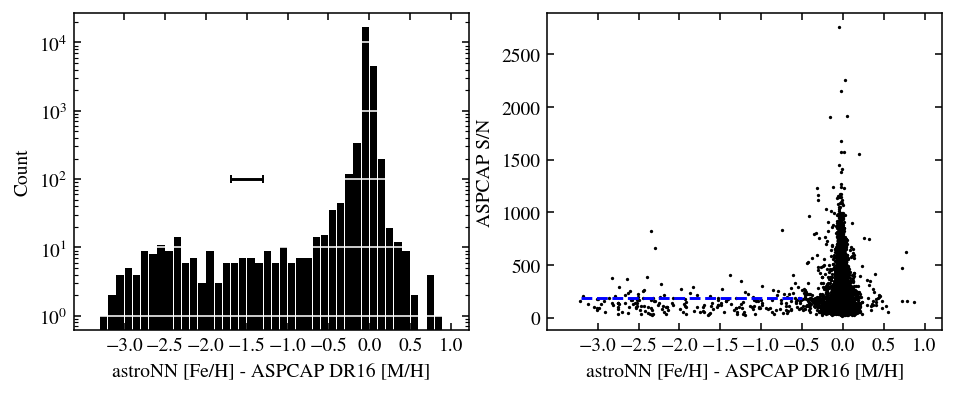

In [10]:
# Isolate astroNN outliers
metals = stellar_params[(pd.notna(stellar_params['ASTRONN_FE_H'])) & (pd.notna(stellar_params['DR16_M_H_COR']))].copy()
fe_diff = metals['ASTRONN_FE_H'] - metals['DR16_M_H_COR']
fe_diff_err = quad_add(rms(metals['ASTRONN_FE_H_ERR']), rms(metals['DR16_M_H_COR_ERR']))

low_fe_snr = rms(metals[fe_diff < -0.5]['DR16_ASPCAP_SNR'])
print('RMS S/N for low-astroNN [Fe/H] targets:', low_fe_snr)

fig, axs = plt.subplots(1,2, figsize=(8, 3), sharex=True)

ax = axs[0]
xmin = -3.4
xmax = 1
xstep = 0.1
bins = np.arange(xmin, xmax+xstep, xstep)
y, x, _ = ax.hist(fe_diff, color='k', bins=bins, rwidth=0.9)
ax.errorbar(-1.5, 100, xerr=fe_diff_err, c='k', capsize=2)
ax.grid(which='major', axis='y', color='w')
ax.set_yscale('log')
ax.set_xlabel('astroNN [Fe/H] - ASPCAP DR16 [M/H]')
ax.set_ylabel('Count')
ax.set_xticks(np.arange(-3, 1.5, 0.5))

ax = axs[1]
ax.scatter(fe_diff, metals['DR16_ASPCAP_SNR'], s=.5, c='k')
ax.plot([-3.2, -0.5], [low_fe_snr, low_fe_snr], linestyle='--', color='b')
ax.set_xlabel('astroNN [Fe/H] - ASPCAP DR16 [M/H]')
ax.set_ylabel('ASPCAP S/N')
plt.show()

[Fe/H] (astroNN - APOKASC) < -0.5: 201
Age (astroNN - APOKASC) < ~4 Gyr: 222


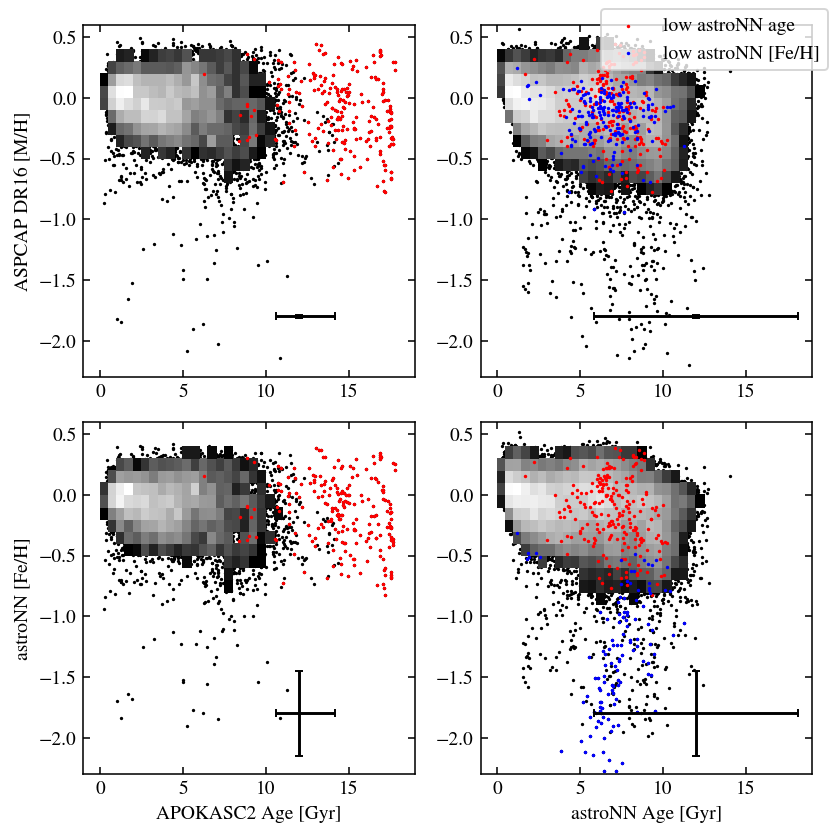

In [11]:
# [Fe/H] vs Age for astroNN vs APOKASC

metals = stellar_params[(pd.notna(stellar_params['ASTRONN_FE_H'])) & (pd.notna(stellar_params['DR16_M_H_COR']))].copy()
ages = stellar_params[(pd.notna(stellar_params['ASTRONN_AGE']) & (pd.notna(stellar_params['APOKASC2_AGE'])))].copy()
low_fe = metals[metals['ASTRONN_FE_H'] - metals['DR16_M_H_COR'] < -0.5]
print('[Fe/H] (astroNN - APOKASC) < -0.5:', low_fe.shape[0])
low_age = ages[prob_outlier(ages['ASTRONN_AGE'] - ages['APOKASC2_AGE']) > 0.5]
print('Age (astroNN - APOKASC) < ~4 Gyr:', low_age.shape[0])
# print('Both outliers:', low_fe.loc[low_age.index].shape[0])

fig, axs = plt.subplots(2, 2, figsize=(6, 6), tight_layout=True)

# Age
ax = axs[0,0]
ax.scatter(metals['APOKASC2_AGE'], metals['DR16_M_H_COR'], c='k', s=.5)
ax.hist2d(metals['APOKASC2_AGE'], metals['DR16_M_H_COR'], 
          bins=[np.arange(0, 19.5, .5), np.arange(-2.3, 0.7, 0.1)], 
          cmap='gray', norm=colors.LogNorm(), cmin=10)
ax.errorbar(12, -1.8,
            xerr=[[rms(metals['APOKASC2_AGE_MERR'])],
                  [rms(metals['APOKASC2_AGE_PERR'])]],
            yerr=rms(metals['DR16_M_H_COR_ERR']),
            c='k', capsize=2)
ax.scatter(low_age['APOKASC2_AGE'], low_age['DR16_M_H_COR'], c='r', s=.6, label='low astroNN age')
ax.scatter(low_fe['APOKASC2_AGE'], low_fe['DR16_M_H_COR'], c='b', s=.6, label='low astroNN [Fe/H]')
ax.set_xlim((-1, 19))
ax.set_ylim((-2.3, 0.6))
# ax.set_xlabel('APOKASC2 Age [Gyr]')
ax.set_ylabel('ASPCAP DR16 [M/H]')

ax = axs[0,1]
ax.scatter(metals['ASTRONN_AGE'], metals['DR16_M_H_COR'], c='k', s=.5)
ax.hist2d(metals['ASTRONN_AGE'], metals['DR16_M_H_COR'], 
          bins=[np.arange(0, 19.5, .5), np.arange(-2.3, 0.7, 0.1)], 
          cmap='gray', norm=colors.LogNorm(), cmin=10)
ax.errorbar(12, -1.8,
            xerr=rms(metals['ASTRONN_AGE']),
            yerr=rms(metals['DR16_M_H_COR_ERR']),
            c='k', capsize=2)
ax.scatter(low_age['ASTRONN_AGE'], low_age['DR16_M_H_COR'], c='r', s=.6)
ax.scatter(low_fe['ASTRONN_AGE'], low_fe['DR16_M_H_COR'], c='b', s=.6)
ax.set_xlim((-1, 19))
ax.set_ylim((-2.3, 0.6))
# ax.set_xlabel('astroNN Age [Gyr]')
# ax.set_ylabel('ASPCAP DR16 [M/H]')

ax = axs[1,0]
ax.scatter(metals['APOKASC2_AGE'], metals['ASTRONN_FE_H'], c='k', s=.5)
ax.hist2d(metals['APOKASC2_AGE'], metals['ASTRONN_FE_H'], 
          bins=[np.arange(0, 19.5, .5), np.arange(-2.3, 0.7, 0.1)], 
          cmap='gray', norm=colors.LogNorm(), cmin=10)
ax.errorbar(12, -1.8,
            xerr=[[rms(metals['APOKASC2_AGE_MERR'])],
                  [rms(metals['APOKASC2_AGE_PERR'])]],
            yerr=rms(metals['ASTRONN_FE_H']),
            c='k', capsize=2)
ax.scatter(low_age['APOKASC2_AGE'], low_age['ASTRONN_FE_H'], c='r', s=.6)
ax.scatter(low_fe['APOKASC2_AGE'], low_fe['ASTRONN_FE_H'], c='b', s=.6)
ax.set_xlim((-1, 19))
ax.set_ylim((-2.3, 0.6))
ax.set_xlabel('APOKASC2 Age [Gyr]')
ax.set_ylabel('astroNN [Fe/H]')

ax = axs[1,1]
ax.scatter(metals['ASTRONN_AGE'], metals['ASTRONN_FE_H'], c='k', s=.5)
ax.hist2d(metals['ASTRONN_AGE'], metals['ASTRONN_FE_H'], 
          bins=[np.arange(0, 19.5, .5), np.arange(-2.3, 0.7, 0.1)], 
          cmap='gray', norm=colors.LogNorm(), cmin=10)
ax.errorbar(12, -1.8,
            xerr=rms(metals['ASTRONN_AGE']),
            yerr=rms(metals['ASTRONN_FE_H']),
            c='k', capsize=2)
ax.scatter(low_age['ASTRONN_AGE'], low_age['ASTRONN_FE_H'], c='r', s=.6)
ax.scatter(low_fe['ASTRONN_AGE'], low_fe['ASTRONN_FE_H'], c='b', s=.6)
ax.set_xlim((-1, 19))
ax.set_ylim((-2.3, 0.6))
ax.set_xlabel('astroNN Age [Gyr]')
# ax.set_ylabel('astroNN [Fe/H]')

fig.legend()
plt.show()

In [12]:
### Note: there are no objects that are abnormally low in astroNN [Fe/H] which also have APOKASC ages.

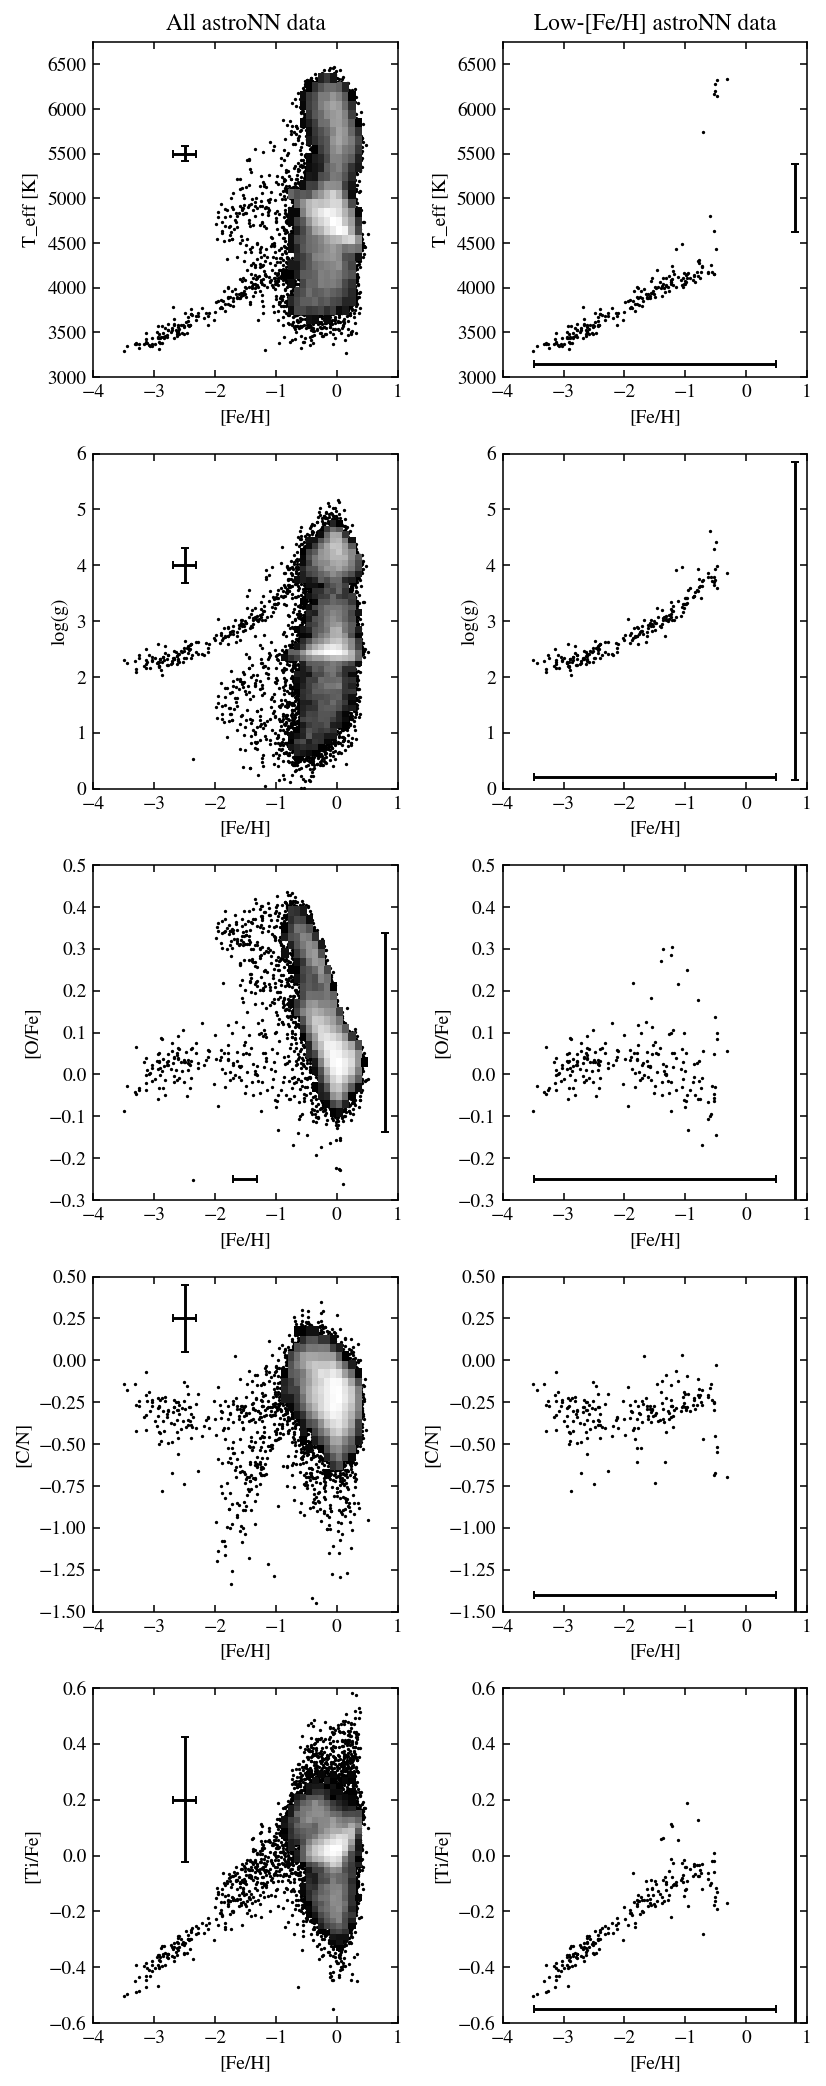

In [13]:
# Investigate low-[Fe/H] astroNN data

metals = stellar_params[(pd.notna(stellar_params['ASTRONN_FE_H'])) & (pd.notna(stellar_params['DR16_M_H_COR']))].copy()
low_fe = metals[metals['ASTRONN_FE_H'] - metals['DR16_M_H_COR'] < -0.5]

fig, axs = plt.subplots(5, 2, figsize=(6, 15), tight_layout=True)

# Teff
ax = axs[0,0]
ax.set_title('All astroNN data')
ax.scatter(metals['ASTRONN_FE_H'], metals['ASTRONN_TEFF'], c='k', s=.5)
ax.hist2d(metals['ASTRONN_FE_H'], metals['ASTRONN_TEFF'], 
          bins=[np.arange(-4, 1.1, 0.1), np.arange(3000, 6600, 100)], 
          cmap='gray', norm=colors.LogNorm(), cmin=10)
ax.errorbar(-2.5, 5500, 
            xerr=rms(metals['ASTRONN_FE_H_ERR']), 
            yerr=rms(metals['ASTRONN_TEFF_ERR']), 
            c='k', capsize=2)
ax.set_xlim((-4, 1))
ax.set_ylim((3000, 6750))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('T_eff [K]')

ax = axs[0,1]
ax.set_title('Low-[Fe/H] astroNN data')
ax.scatter(low_fe['ASTRONN_FE_H'], low_fe['ASTRONN_TEFF'], c='k', s=.5)
ax.errorbar(-1.5, 3150, 
            xerr=rms(low_fe['ASTRONN_FE_H_ERR']), 
            c='k', capsize=2)
ax.errorbar(0.8, 5000,
            yerr=rms(low_fe['ASTRONN_TEFF_ERR']), 
            c='k', capsize=2)
ax.set_xlim((-4, 1))
ax.set_ylim((3000, 6750))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('T_eff [K]')

# log(g)
ax = axs[1,0]
ax.scatter(metals['ASTRONN_FE_H'], metals['ASTRONN_LOGG'], c='k', s=.5)
ax.hist2d(metals['ASTRONN_FE_H'], metals['ASTRONN_LOGG'], 
          bins=[np.arange(-4, 1.1, 0.1), np.arange(0, 5.1, 0.1)], 
          cmap='gray', norm=colors.LogNorm(), cmin=10)
ax.errorbar(-2.5, 4, 
            xerr=rms(metals['ASTRONN_FE_H_ERR']), 
            yerr=rms(metals['ASTRONN_LOGG_ERR']), 
            c='k', capsize=2)
ax.set_xlim((-4, 1))
ax.set_ylim((0, 6))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('log(g)')

ax = axs[1,1]
ax.scatter(low_fe['ASTRONN_FE_H'], low_fe['ASTRONN_LOGG'], c='k', s=.5)
ax.errorbar(-1.5, 0.2, 
            xerr=rms(low_fe['ASTRONN_FE_H_ERR']), 
            c='k', capsize=2)
ax.errorbar(0.8, 3,
            yerr=rms(low_fe['ASTRONN_LOGG_ERR']),
            c='k', capsize=2)
ax.set_xlim((-4, 1))
ax.set_ylim((0, 6))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('log(g)')

# [O/Fe]
ax = axs[2,0]
ax.scatter(metals['ASTRONN_FE_H'], metals['ASTRONN_O_FE'], c='k', s=.5)
ax.hist2d(metals['ASTRONN_FE_H'], metals['ASTRONN_O_FE'], 
          bins=[np.arange(-4, 1.1, 0.1), np.arange(-0.3, 0.52, 0.02)],
          cmap='gray', norm=colors.LogNorm(), cmin=10)
ax.errorbar(-1.5, -0.25, 
            xerr=rms(metals['ASTRONN_FE_H_ERR']),  
            c='k', capsize=2)
ax.errorbar(0.8, 0.1, 
            yerr=rms(metals['ASTRONN_O_FE_ERR']), 
            c='k', capsize=2)
ax.set_xlim((-4, 1))
ax.set_ylim((-0.3, 0.5))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[O/Fe]')

ax = axs[2,1]
ax.scatter(low_fe['ASTRONN_FE_H'], low_fe['ASTRONN_O_FE'], c='k', s=.5)
ax.errorbar(-1.5, -0.25, 
            xerr=rms(low_fe['ASTRONN_FE_H_ERR']), 
            c='k', capsize=2)
ax.errorbar(0.8, 0.1,
            yerr=rms(low_fe['ASTRONN_O_FE_ERR']),
            c='k', capsize=2)
ax.set_xlim((-4, 1))
ax.set_ylim((-0.3, 0.5))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[O/Fe]')

# [C/N]
ax = axs[3,0]
ax.scatter(metals['ASTRONN_FE_H'], metals['ASTRONN_C_N'], c='k', s=.5)
ax.hist2d(metals['ASTRONN_FE_H'], metals['ASTRONN_C_N'], 
          bins=[np.arange(-4, 1.1, 0.1), np.arange(-1.5, 0.55, 0.05)], 
          cmap='gray', norm=colors.LogNorm(), cmin=10)
ax.errorbar(-2.5, 0.25, 
            xerr=rms(metals['ASTRONN_FE_H_ERR']), 
            yerr=rms(metals['ASTRONN_C_N_ERR']), 
            c='k', capsize=2)
ax.set_xlim((-4, 1))
ax.set_ylim((-1.5, 0.5))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[C/N]')

ax = axs[3,1]
ax.scatter(low_fe['ASTRONN_FE_H'], low_fe['ASTRONN_C_N'], c='k', s=.5)
ax.errorbar(-1.5, -1.4, 
            xerr=rms(low_fe['ASTRONN_FE_H_ERR']), 
            c='k', capsize=2)
ax.errorbar(0.8, -0.5,
            yerr=rms(low_fe['ASTRONN_C_N_ERR']),
            c='k', capsize=2)
ax.set_xlim((-4, 1))
ax.set_ylim((-1.5, 0.5))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[C/N]')

# [Ti/Fe]
ax = axs[4,0]
ax.scatter(metals['ASTRONN_FE_H'], metals['ASTRONN_TI_FE'], c='k', s=.5)
ax.hist2d(metals['ASTRONN_FE_H'], metals['ASTRONN_TI_FE'], 
          bins=[np.arange(-4, 1.1, 0.1), np.arange(-0.6, 0.62, 0.02)], 
          cmap='gray', norm=colors.LogNorm(), cmin=10)
ax.errorbar(-2.5, 0.2, 
            xerr=rms(metals['ASTRONN_FE_H_ERR']), 
            yerr=rms(metals['ASTRONN_TI_FE_ERR']), 
            c='k', capsize=2)
ax.set_xlim((-4, 1))
ax.set_ylim((-0.6, 0.6))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[Ti/Fe]')

ax = axs[4,1]
ax.scatter(low_fe['ASTRONN_FE_H'], low_fe['ASTRONN_TI_FE'], c='k', s=.5)
ax.errorbar(-1.5, -0.55, 
            xerr=rms(low_fe['ASTRONN_FE_H_ERR']), 
            c='k', capsize=2)
ax.errorbar(0.8, 0,
            yerr=rms(low_fe['ASTRONN_TI_FE_ERR']),
            c='k', capsize=2)
ax.set_xlim((-4, 1))
ax.set_ylim((-0.6, 0.6))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[Ti/Fe]')

plt.savefig('astroNN_properties.pdf')
plt.show()

In [14]:
print(low_fe[['ASTRONN_FE_H', 'ASTRONN_FE_H_ERR', 'DR16_M_H_COR', 'DR16_M_H_COR_ERR']])

                    ASTRONN_FE_H  ASTRONN_FE_H_ERR  DR16_M_H_COR  \
APOGEE_ID                                                          
2M18511690+4701553     -0.531696          0.170746      0.098016   
2M19161179+4705132     -1.020016          0.321723     -0.281329   
2M19450483+4701306     -0.985840          0.533833      0.003346   
2M18492836+4712083     -1.288638          0.675542     -0.083318   
2M19443810+4720294     -3.292341          4.026917     -0.936659   
...                          ...               ...           ...   
2M18522807+4624286     -1.790738          1.002845     -0.259149   
2M19510930+4628598     -3.126466          3.539053     -0.303649   
2M19165673+4638385     -1.078051          0.455590     -0.019090   
2M18502166+4643358     -1.350272          0.743132     -0.059639   
2M18441633+4658288     -2.560939          2.367520     -0.087046   

                    DR16_M_H_COR_ERR  
APOGEE_ID                             
2M18511690+4701553          0.037074 

### log(g)

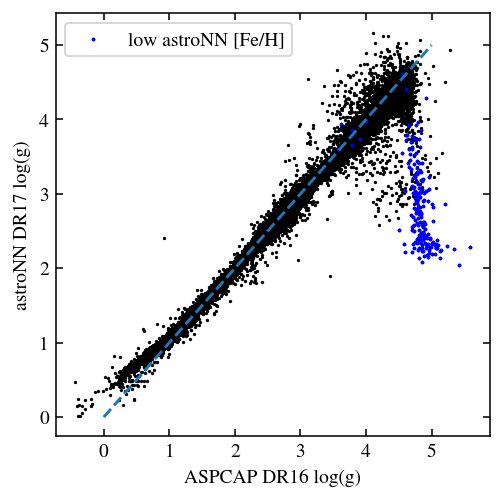

In [15]:
low_fe = stellar_params[stellar_params['ASTRONN_FE_H'] - stellar_params['DR16_M_H_COR'] < -0.5].copy()
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(stellar_params['DR16_LOGG_COR'], stellar_params['ASTRONN_LOGG'], c='k', s=.5)
ax.scatter(low_fe['DR16_LOGG_COR'], low_fe['ASTRONN_LOGG'], c='b', s=1, label='low astroNN [Fe/H]')
ax.plot([0, 5], [0, 5], linestyle='--')
ax.set_xlabel('ASPCAP DR16 log(g)')
ax.set_ylabel('astroNN DR17 log(g)')
ax.legend()
plt.show()

### Age - alpha relation

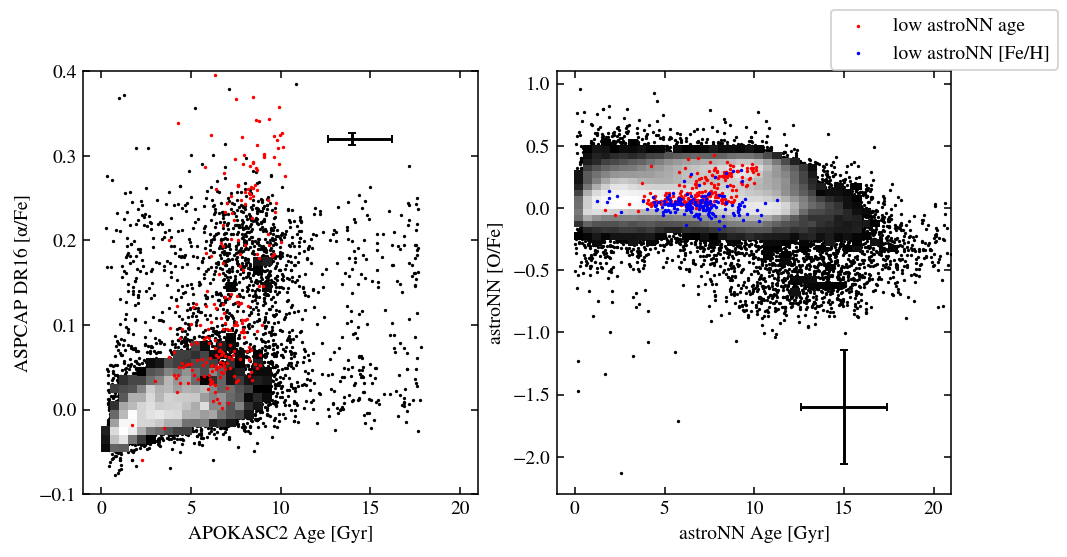

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# APOKASC data
ax = axs[0]
age_alpha = stellar_params[(pd.notna(stellar_params['APOKASC2_AGE'])) & (pd.notna(stellar_params['DR16_ALP_M_COR']))].copy()
low_fe = age_alpha[age_alpha['ASTRONN_FE_H'] - age_alpha['DR16_M_H_COR'] < -0.5].copy()
low_age = age_alpha[pd.notna(age_alpha['ASTRONN_AGE']) & pd.notna(age_alpha['APOKASC2_AGE'])].copy()
low_age = low_age[prob_outlier(low_age['ASTRONN_AGE'] - low_age['APOKASC2_AGE']) > 0.5]
ax.scatter(age_alpha['APOKASC2_AGE'], age_alpha['DR16_ALP_M_COR'], c='k', s=.5)
ax.hist2d(age_alpha['APOKASC2_AGE'], age_alpha['DR16_ALP_M_COR'], 
          bins=[np.arange(0, 20.5, 0.5), np.arange(-0.1, 0.41, 0.01)], 
          cmap='gray', norm=colors.LogNorm(), cmin=10)
ax.scatter(low_age['ASTRONN_AGE'], low_age['ASTRONN_O_FE'], c='r', s=.6)
ax.scatter(low_fe['ASTRONN_AGE'], low_fe['ASTRONN_O_FE'], c='b', s=.6)
ax.errorbar(14, 0.32, 
            xerr=[[rms(age_alpha['APOKASC2_AGE_MERR'])],
                  [rms(age_alpha['APOKASC2_AGE_PERR'])]], 
            yerr=rms(age_alpha['DR16_ALP_M_COR_ERR']), c='k', capsize=2)
ax.set_xlim((-1, 21))
ax.set_xlabel('APOKASC2 Age [Gyr]')
ax.set_ylabel('ASPCAP DR16 [α/Fe]')

# astroNN data
ax = axs[1]
age_alpha = stellar_params[(pd.notna(stellar_params['ASTRONN_AGE'])) & (pd.notna(stellar_params['ASTRONN_O_FE']))].copy()
age_alpha.drop(age_alpha[(age_alpha['ASTRONN_O_FE'] < -3) | (age_alpha['ASTRONN_O_FE'] > 1)].index, inplace=True)
age_alpha.drop(age_alpha[age_alpha['ASTRONN_O_FE_ERR'] > 4].index, inplace=True)
low_fe = age_alpha[age_alpha['ASTRONN_FE_H'] - age_alpha['DR16_M_H_COR'] < -0.5].copy()
low_age = age_alpha[pd.notna(age_alpha['ASTRONN_AGE']) & pd.notna(age_alpha['APOKASC2_AGE'])].copy()
low_age = low_age[prob_outlier(low_age['ASTRONN_AGE'] - low_age['APOKASC2_AGE']) > 0.5]
ax.scatter(age_alpha['ASTRONN_AGE'], age_alpha['ASTRONN_O_FE'], c='k', s=.5)
ax.hist2d(age_alpha['ASTRONN_AGE'], age_alpha['ASTRONN_O_FE'], 
          bins=[np.arange(0, 20.5, 0.5), np.arange(-3, 1.05, 0.05)], 
          cmap='gray', norm=colors.LogNorm(), cmin=10)
ax.scatter(low_age['ASTRONN_AGE'], low_age['ASTRONN_O_FE'], c='r', s=.6, label='low astroNN age')
ax.scatter(low_fe['ASTRONN_AGE'], low_fe['ASTRONN_O_FE'], c='b', s=.6, label='low astroNN [Fe/H]')
ax.errorbar(15, -1.6, xerr=rms(age_alpha['ASTRONN_AGE_ERR']), yerr=rms(age_alpha['ASTRONN_O_FE_ERR']), c='k', capsize=2)
ax.set_xlim((-1, 21))
ax.set_ylim((-2.3, 1.1))
ax.set_xlabel('astroNN Age [Gyr]')
ax.set_ylabel('astroNN [O/Fe]')
fig.legend()
plt.show()

### Carbon isotope ratios

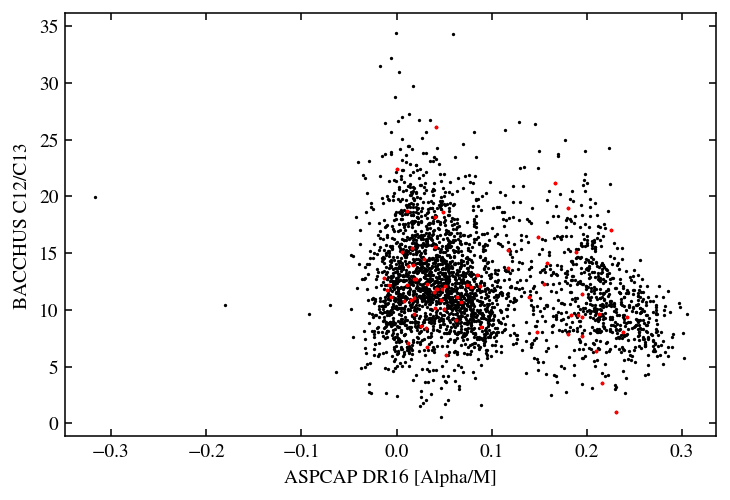

In [17]:
ciso = stellar_params[pd.notna(stellar_params['C12C13'])].copy()
# Stars with astroNN metallicities well below ASPCAP DR16
low_fe = ciso[ciso['ASTRONN_FE_H'] - ciso['DR16_M_H_COR'] < -0.5].copy()
# Stars with astroNN ages well below APOKASC2
low_age = ciso[pd.notna(ciso['ASTRONN_AGE']) & pd.notna(ciso['APOKASC2_AGE'])].copy()
low_age = low_age[prob_outlier(low_age['ASTRONN_AGE'] - low_age['APOKASC2_AGE']) > 0.5]

fix, ax = plt.subplots()
ax.scatter(ciso['DR16_ALP_M_COR'], ciso['C12C13'], c='k', s=.5)
ax.scatter(low_age['DR16_ALP_M_COR'], low_age['C12C13'], c='r', s=1, label='Low astroNN ages')
ax.scatter(low_fe['DR16_ALP_M_COR'], low_fe['C12C13'], c='b', s=1, label='Low astroNN [Fe/H]')
ax.set_xlabel('ASPCAP DR16 [Alpha/M]')
ax.set_ylabel('BACCHUS C12/C13')
plt.show()

### CMDs

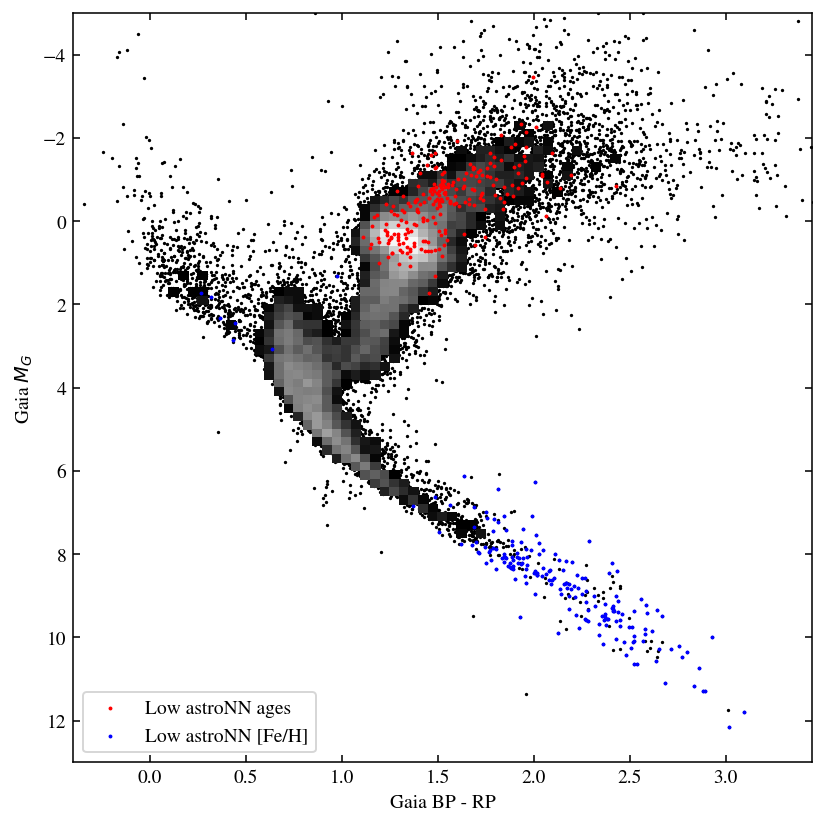

In [18]:
# Select only positive parallaxes
cmd = stellar_params[stellar_params['GAIA_PARALLAX_DR2'] > 0].copy()
# Use APOKASC2 A_V extinction where possible
cmd['APOKASC2_AV'] = cmd['APOKASC2_AV'].replace(np.nan, 0)
# Calculate distance modulus from Gaia parallaxes (given in mas)
cmd['GAIA_DIST_MOD'] = 5*np.log10((1e-3 * cmd['GAIA_PARALLAX_DR2'])**-1) - 5 + cmd['APOKASC2_AV']
# Absolute Gaia G-band magnitude
cmd['GAIA_ABS_MAG'] = cmd['GAIA_PHOT_G_MEAN_MAG_DR2'] - cmd['GAIA_DIST_MOD']
# Gaia BP - RP color
cmd['GAIA_COLOR'] = cmd['GAIA_PHOT_BP_MEAN_MAG_DR2'] - cmd['GAIA_PHOT_RP_MEAN_MAG_DR2']
# Stars with astroNN metallicities well below ASPCAP DR16
low_fe = cmd[cmd['ASTRONN_FE_H'] - cmd['DR16_M_H_COR'] < -0.5].copy()
# Stars with astroNN ages well below APOKASC2
low_age = cmd[pd.notna(cmd['ASTRONN_AGE']) & pd.notna(cmd['APOKASC2_AGE'])].copy()
low_age = low_age[prob_outlier(low_age['ASTRONN_AGE'] - low_age['APOKASC2_AGE']) > 0.5]

# Plot color-magnitude diagram
fig, ax = plt.subplots(tight_layout=True, figsize=(6, 6))
ax.scatter(cmd['GAIA_COLOR'], cmd['GAIA_ABS_MAG'], c='k', s=.5)
ax.hist2d(cmd['GAIA_COLOR'], cmd['GAIA_ABS_MAG'], 
          bins=[np.arange(-0.4, 3.5, 0.05), np.arange(-5, 13, 0.2)], 
          cmap='gray', norm=colors.LogNorm(), cmin=10)
ax.scatter(low_age['GAIA_COLOR'], low_age['GAIA_ABS_MAG'], c='r', s=1, label='Low astroNN ages')
ax.scatter(low_fe['GAIA_COLOR'], low_fe['GAIA_ABS_MAG'], c='b', s=1, label='Low astroNN [Fe/H]')
ax.set_ylim((13, -5))
ax.set_xlabel('Gaia BP - RP')
ax.set_ylabel('Gaia $M_G$')
ax.legend()
plt.savefig('Gaia_CMD.png')
plt.show()

## Alpha vs Fe

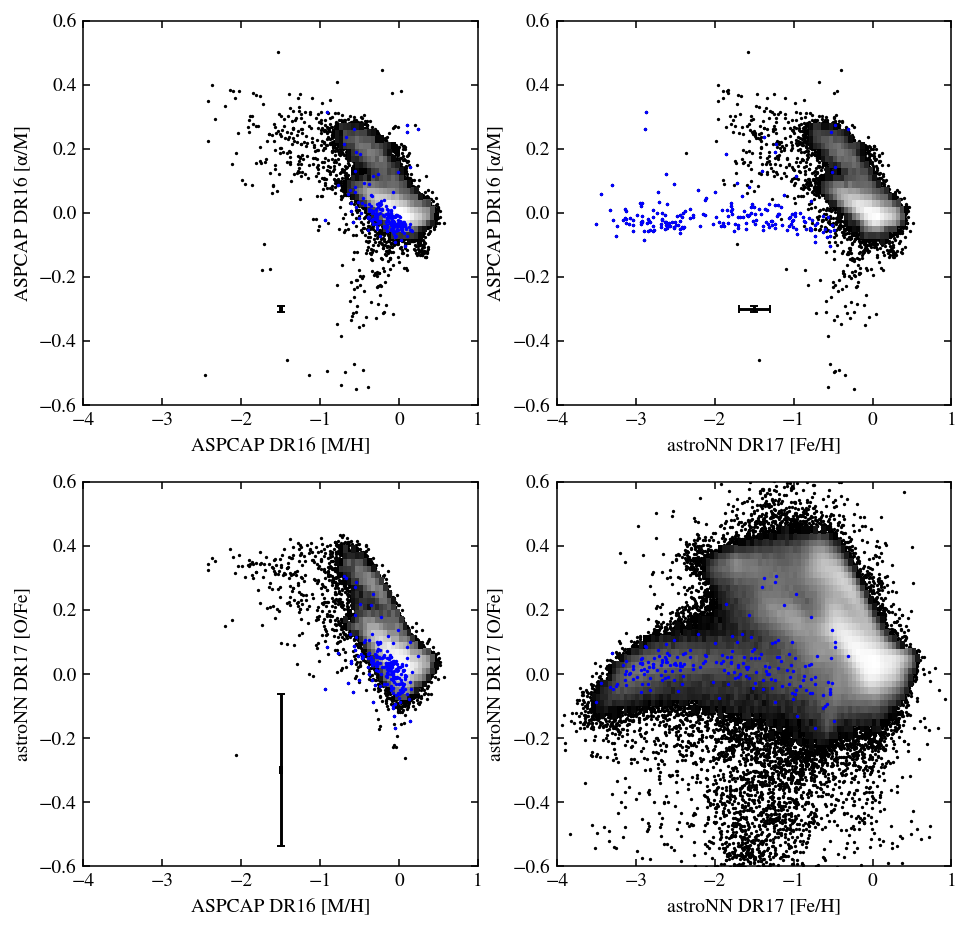

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# plot bounds
xmin = -4
xmax = 1
dx = 0.05
ymin = -0.6
ymax = 0.6
dy = 0.02

low_fe = stellar_params[stellar_params['ASTRONN_FE_H'] - stellar_params['DR16_M_H_COR'] < -0.5]

ax = axs[0,0]
abund = stellar_params[pd.notna(stellar_params['DR16_M_H_COR']) & pd.notna(stellar_params['DR16_ALP_M_COR'])].copy()
ax.scatter(abund['DR16_M_H_COR'], abund['DR16_ALP_M_COR'], s=.5, c='k')
ax.hist2d(abund['DR16_M_H_COR'], abund['DR16_ALP_M_COR'], 
          bins=[np.arange(xmin, xmax+dx, dx), np.arange(ymin, ymax+dy, dy)], 
          cmap='gray', norm=colors.LogNorm(), cmin=10)
ax.errorbar(-1.5, -0.3,
            xerr=rms(abund['DR16_M_H_COR_ERR']),
            yerr=rms(abund['DR16_ALP_M_COR_ERR']),
            c='k', capsize=2)
ax.scatter(low_fe['DR16_M_H_COR'], low_fe['DR16_ALP_M_COR'], c='b', s=.6, label='Low astroNN [Fe/H]')
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
ax.set_xlabel('ASPCAP DR16 [M/H]')
ax.set_ylabel('ASPCAP DR16 [α/M]')

ax = axs[0,1]
abund = stellar_params[pd.notna(stellar_params['ASTRONN_FE_H']) & pd.notna(stellar_params['DR16_ALP_M_COR'])].copy()
ax.scatter(abund['ASTRONN_FE_H'], abund['DR16_ALP_M_COR'], s=.5, c='k')
ax.hist2d(abund['ASTRONN_FE_H'], abund['DR16_ALP_M_COR'], 
          bins=[np.arange(xmin, xmax+dx, dx), np.arange(ymin, ymax+dy, dy)], 
          cmap='gray', norm=colors.LogNorm(), cmin=10)
ax.errorbar(-1.5, -0.3,
            xerr=rms(abund['ASTRONN_FE_H_ERR']),
            yerr=rms(abund['DR16_ALP_M_COR_ERR']),
            c='k', capsize=2)
ax.scatter(low_fe['ASTRONN_FE_H'], low_fe['DR16_ALP_M_COR'], c='b', s=.6)
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
ax.set_xlabel('astroNN DR17 [Fe/H]')
ax.set_ylabel('ASPCAP DR16 [α/M]')

ax = axs[1,0]
abund = stellar_params[pd.notna(stellar_params['DR16_M_H_COR']) & pd.notna(stellar_params['ASTRONN_O_FE'])].copy()
ax.scatter(abund['DR16_M_H_COR'], abund['ASTRONN_O_FE'], s=.5, c='k')
ax.hist2d(abund['DR16_M_H_COR'], abund['ASTRONN_O_FE'], 
          bins=[np.arange(xmin, xmax+dx, dx), np.arange(ymin, ymax+dy, dy)], 
          cmap='gray', norm=colors.LogNorm(), cmin=10)
ax.errorbar(-1.5, -0.3,
            xerr=rms(abund['DR16_M_H_COR_ERR']),
            yerr=rms(abund['ASTRONN_O_FE_ERR']),
            c='k', capsize=2)
ax.scatter(low_fe['DR16_M_H_COR'], low_fe['ASTRONN_O_FE'], c='b', s=.6)
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
ax.set_xlabel('ASPCAP DR16 [M/H]')
ax.set_ylabel('astroNN DR17 [O/Fe]')

ax = axs[1,1]
abund = stellar_params[pd.notna(stellar_params['ASTRONN_FE_H']) & pd.notna(stellar_params['ASTRONN_O_FE'])].copy()
ax.scatter(abund['ASTRONN_FE_H'], abund['ASTRONN_O_FE'], s=.5, c='k')
ax.hist2d(abund['ASTRONN_FE_H'], abund['ASTRONN_O_FE'], 
          bins=[np.arange(xmin, xmax+dx, dx), np.arange(ymin, ymax+dy, dy)], 
          cmap='gray', norm=colors.LogNorm(), cmin=10)
# ax.errorbar(-1.5, -0.3,
#             xerr=rms(abund['ASTRONN_FE_H_ERR']),
#             yerr=rms(abund['ASTRONN_O_FE_ERR']),
#             c='k', capsize=2)
ax.scatter(low_fe['ASTRONN_FE_H'], low_fe['ASTRONN_O_FE'], c='b', s=.6)
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
ax.set_xlabel('astroNN DR17 [Fe/H]')
ax.set_ylabel('astroNN DR17 [O/Fe]')

plt.show()

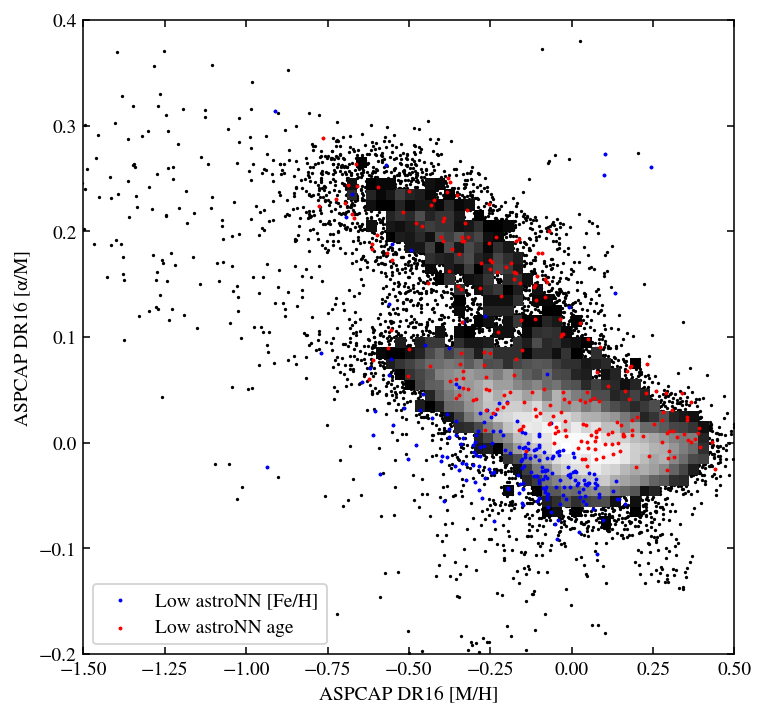

In [21]:
fig, ax = plt.subplots(figsize=(6,6))
# plot bounds
xmin = -1.5
xmax = 0.5
dx = 0.03
ymin = -0.2
ymax = 0.4
dy = 0.01
low_fe = stellar_params[stellar_params['ASTRONN_FE_H'] - stellar_params['DR16_M_H_COR'] < -0.5]
low_age = stellar_params[pd.notna(stellar_params['ASTRONN_AGE']) & pd.notna(stellar_params['APOKASC2_AGE'])].copy()
low_age = low_age[prob_outlier(low_age['ASTRONN_AGE'] - low_age['APOKASC2_AGE']) > 0.5]
abund = stellar_params[pd.notna(stellar_params['DR16_M_H_COR']) & pd.notna(stellar_params['DR16_ALP_M_COR'])].copy()
ax.scatter(abund['DR16_M_H_COR'], abund['DR16_ALP_M_COR'], s=.5, c='k')
ax.hist2d(abund['DR16_M_H_COR'], abund['DR16_ALP_M_COR'], 
          bins=[np.arange(xmin, xmax+dx, dx), np.arange(ymin, ymax+dy, dy)], 
          cmap='gray', norm=colors.LogNorm(), cmin=10)
ax.errorbar(-1.5, -0.3,
            xerr=rms(abund['DR16_M_H_COR_ERR']),
            yerr=rms(abund['DR16_ALP_M_COR_ERR']),
            c='k', capsize=2)
ax.scatter(low_fe['DR16_M_H_COR'], low_fe['DR16_ALP_M_COR'], c='b', s=1, label='Low astroNN [Fe/H]')
ax.scatter(low_age['DR16_M_H_COR'], low_age['DR16_ALP_M_COR'], c='r', s=1, label='Low astroNN age')
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
ax.set_xlabel('ASPCAP DR16 [M/H]')
ax.set_ylabel('ASPCAP DR16 [α/M]')
ax.legend()
plt.savefig('alpha_fe.png')
plt.show()